In [37]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”
── Conflicts ────

## Preliminary Exploratory Data Analysis:
1) Reading the dataset from the web into R

In [38]:
forest_fire_data_raw <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)
head(forest_fire_data_raw) #previewing the first 6 rows of the dataset

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
2,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
3,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
4,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
5,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire
6,06,06,2012,31,67,14,0,82.6,5.8,22.2,3.1,7,2.5,fire


Here is what the column headings mean:
* day/month/year: indicate the day/month/year that the observation was taken, respectively.
* Temperature: Maximum Temperature on that day (Celsius)
* RH: Realtive Humidity (%)
* Ws: Wind Speed (km/h)
* Rain: Total that day (mm)
* FFMC: Fine Fuel Moisture Code Index from FWI system
* DMC: Duff Moisture Code Index from FWI system
* DC: Drought Code Index from FWI system
* ISI: Initial Spread Index from FWI system
* BUI: Buildup index from FWI system
* FWI: Fire Weather Index
* Classes: either "not fire" or "fire"

2) Cleaning and Wrangling the Data into a Tidy Format
* The data is already in a tidy form as all observations are split into individual rows, each column is a single variable and each value is in a single cell.
* However, to make the data more usable, we decided to convert some of the columns from characters to factors (Classes) and numeric values (Temperature:FWI).

In [69]:
forest_fire_data_collect <- collect(forest_fire_data_raw)

forest_fire_data <- forest_fire_data_collect %>%
    mutate(Classes = as.factor(Classes),
           Temperature = as.numeric(Temperature, na.rm = TRUE),
           RH = as.numeric(RH, na.rm = TRUE),
           Ws = as.numeric(Ws, na.rm = TRUE),
           Rain = as.numeric(Rain, na.rm = TRUE),
           FFMC = as.numeric(FFMC, na.rm = TRUE),
           DMC = as.numeric(DMC, na.rm = TRUE),
           DC = as.numeric(DC, na.rm = TRUE),
           ISI = as.numeric(ISI, na.rm = TRUE),
           BUI = as.numeric(BUI, na.rm = TRUE),
           FWI = as.numeric(FWI, na.rm = TRUE))

head(forest_fire_data)

Warning message:
“Problem with `mutate()` input `Temperature`.
ℹ NAs introduced by coercion
ℹ Input `Temperature` is `as.numeric(Temperature, na.rm = TRUE)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `RH`.
ℹ NAs introduced by coercion
ℹ Input `RH` is `as.numeric(RH, na.rm = TRUE)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `Ws`.
ℹ NAs introduced by coercion
ℹ Input `Ws` is `as.numeric(Ws, na.rm = TRUE)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `Rain`.
ℹ NAs introduced by coercion
ℹ Input `Rain` is `as.numeric(Rain, na.rm = TRUE)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `FFMC`.
ℹ NAs introduced by coercion
ℹ Input `FFMC` is `as.numeric(

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
2,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
3,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
4,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
5,05,06,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
6,06,06,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


#### Extracting Training Data
* 75% of the data was used as training data in this analysis

In [70]:
set.seed(3456) 

forest_split <- initial_split(forest_fire_data, prop = 0.75, strata = Classes)  
forest_fire_training <- training(forest_split)   
forest_fire_testing <- testing(forest_split)

head(forest_fire_training)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
2,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
3,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
4,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
5,05,06,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
6,06,06,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


3) Creating a Summary Table
* We wanted to create a summary table that showed the number of observations in both the "fire" and "not fire" classes that we are using as well as the means of the predictor variables we plan to use (Temperature:Rain).

In [71]:
fail()

forest_fire_summary <- forest_fire_training %>%
    group_by(Classes) %>%
    summarize(n = n()) 

forest_fire_summary

ERROR: Error in fail(): could not find function "fail"


4) Creating a Vsiaulization for Our Training Data
* We wanted to visualize the distributions of our predictor variables (Temperature:Rain)

factor,values
<chr>,"<dbl[,1]>"
scaled_temperature,-0.7704208
scaled_RH,-0.3851683
scaled_Ws,0.8275509
⋮,⋮
scaled_RH,0.07423636
scaled_Ws,-0.21209543
scaled_Rain,-0.27979651


$x
[1] "Value"

attr(,"class")
[1] "labels"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 8 rows containing non-finite values (stat_bin).”


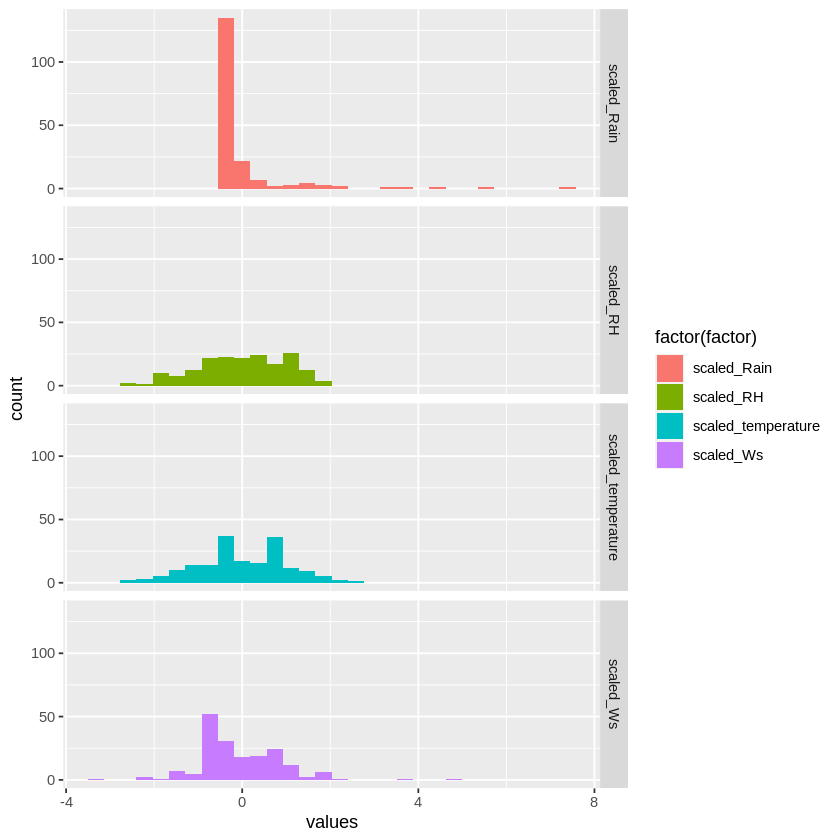

In [78]:
forest_fire_visualization_table <- forest_fire_training %>%
    mutate(scaled_temperature = scale(Temperature), 
           scaled_RH = scale(RH),
           scaled_Ws = scale(Ws),
           scaled_Rain = scale(Rain))%>%
    pivot_longer(cols = scaled_temperature:scaled_Rain, names_to = "factor", values_to = "values") %>%
    select(factor, values)
forest_fire_visualization_table

forest_fire_visualization <- forest_fire_visualization_table %>%
    ggplot(aes(x = values, fill = factor(factor))) +
    geom_histogram(position = "identity") +
    facet_grid(factor ~ .)
    labs(x = "Value")

forest_fire_visualization